<center>
    <h1>Notebook untuk Pipeline RAG</h1>
</center>

> Dokumen yang digunakan dalam pengerjakan RAG ini diperoleh dari [WikiVoyage](https://en.wikivoyage.org/wiki/Main_Page)

### Install Library

In [1]:
!pip install torch transformers==4.45.2 accelerate bitsandbytes==0.43.2 marker-pdf==0.2.17 langchain sentence-transformers faiss-cpu openpyxl pacmap datasets langchain-community ragatouille

### Import Library

In [29]:
from langchain_text_splitters import (
    MarkdownHeaderTextSplitter,
    RecursiveCharacterTextSplitter,
)
from marker.convert import convert_single_pdf
from marker.logger import configure_logging
from marker.models import load_all_models
from tqdm import tqdm
from typing import Optional, List, Tuple
from langchain.docstore.document import Document as LangchainDocument
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
from transformers import AutoTokenizer, Pipeline, AutoModelForCausalLM, BitsAndBytesConfig
from ragatouille import RAGPretrainedModel

import torch
import pandas as pd
import matplotlib.pyplot as plt
import os
import hashlib
import pickle
import pacmap
import numpy as np
import plotly.express as px

## Pre-Process Documents

### Function Declaration

In [3]:
def ParserFileName(filename):
    cleaned_filename = filename.replace(" ", "").replace(".", "")
    if filename.endswith(".pdf"):
        cleaned_filename = cleaned_filename[:-3] + ".pdf"
    return cleaned_filename

In [4]:
def PDFtoMD(fname, reference_folder, model_lst, md_out_path=None):
    pdf_filename = os.path.join(reference_folder, fname)
    md_filename = os.path.splitext(fname)[0] + ".md"

    full_text, _, _ = convert_single_pdf(pdf_filename, model_lst, batch_multiplier=1)

    if md_out_path:
        output_path = os.path.join(md_out_path, md_filename)
        with open(output_path, "w") as f:
            f.write(full_text)
    else:
        return full_text

In [5]:
def ProcessFiles(
    file_key, text_splitter, markdown_splitter, model_lst, reference_folder="./data/"
):
    parsed_file_name = ParserFileName(file_key)
    temp_file_path = os.path.join(reference_folder, parsed_file_name)

    markdown_content = PDFtoMD(parsed_file_name, reference_folder, model_lst)

    header_splits = markdown_splitter.split_text(markdown_content)

    documents = []
    for header_split in header_splits:
        text_splits = text_splitter.split_text(header_split.page_content)

        for part_index, text_split in enumerate(text_splits):
            doc_identifier = f"{file_key}_part_{part_index}"
            hash_hex = hashlib.md5(doc_identifier.encode()).hexdigest()[:10]

            metadata = {
                "document_id": hash_hex,
                "pdf_name": file_key,
                "pdf_part": part_index,
                **header_split.metadata,
            }

            documents.append({"metadata": metadata, "content": text_split})

    return documents

In [6]:
def PDFCounter(directory_path):
    if not os.path.isdir(directory_path):
        print(f"Error: The directory '{directory_path}' does not exist.")
        return []

    return [f for f in os.listdir(directory_path) if f.lower().endswith(".pdf")]


directory = "./data/"
filenames = PDFCounter(directory)
print(f"Number of PDF file: {len(filenames)}")

Number of PDF file: 10


In [7]:
configure_logging()
model_lst = load_all_models()

Loaded detection model vikp/surya_det3 on device cuda with dtype torch.float16
Loaded detection model vikp/surya_layout3 on device cuda with dtype torch.float16
Loaded reading order model vikp/surya_order on device cuda with dtype torch.float16
Loaded recognition model vikp/surya_rec2 on device cuda with dtype torch.float16
Loaded texify model to cuda with torch.float16 dtype


In [8]:
headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
]
chunk_size = 500
chunk_overlap = 100
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size, chunk_overlap=chunk_overlap
)
markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)

### Load Documents

In [9]:
documents = []

for filename in tqdm(filenames):

    print("\nFile: {} \n".format(filename))

    splitted_doc = ProcessFiles(
        filename,
        text_splitter,
        markdown_splitter,
        model_lst,
        reference_folder="./data/",
    )

    documents.append(splitted_doc)

  0%|          | 0/10 [00:00<?, ?it/s]


File: Vietnam.pdf 




Detecting bboxes: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]

Detecting bboxes: 100%|██████████| 9/9 [00:17<00:00,  1.91s/it]

 10%|█         | 1/10 [01:31<13:41, 91.23s/it]


File: Singapore.pdf 




Detecting bboxes: 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]

Detecting bboxes: 100%|██████████| 13/13 [00:21<00:00,  1.64s/it]

 20%|██        | 2/10 [03:49<15:49, 118.64s/it]


File: Philippines.pdf 




Detecting bboxes: 100%|██████████| 19/19 [00:14<00:00,  1.27it/s]

Detecting bboxes: 100%|██████████| 13/13 [00:18<00:00,  1.39s/it]

 30%|███       | 3/10 [05:56<14:19, 122.85s/it]


File: Indonesia.pdf 




Detecting bboxes: 100%|██████████| 17/17 [00:13<00:00,  1.28it/s]

Detecting bboxes: 100%|██████████| 12/12 [00:15<00:00,  1.31s/it]

 40%|████      | 4/10 [07:54<12:04, 120.67s/it]


File: Thailand.pdf 




Detecting bboxes: 100%|██████████| 17/17 [00:12<00:00,  1.36it/s]

Detecting bboxes: 100%|██████████| 11/11 [00:15<00:00,  1.43s/it]

 50%|█████     | 5/10 [09:43<09:42, 116.49s/it]


File: Laos.pdf 




Detecting bboxes: 100%|██████████| 8/8 [00:06<00:00,  1.20it/s]

Detecting bboxes: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]

 60%|██████    | 6/10 [10:37<06:21, 95.33s/it] 


File: Brunei.pdf 




Detecting bboxes: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]

Detecting bboxes: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

 70%|███████   | 7/10 [11:03<03:37, 72.51s/it]


File: Cambodia.pdf 




Detecting bboxes: 100%|██████████| 9/9 [00:06<00:00,  1.45it/s]

Detecting bboxes: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]

 80%|████████  | 8/10 [12:03<02:17, 68.52s/it]


File: Myanmar.pdf 




Detecting bboxes: 100%|██████████| 9/9 [00:05<00:00,  1.52it/s]

Detecting bboxes: 100%|██████████| 6/6 [00:07<00:00,  1.20s/it]

 90%|█████████ | 9/10 [13:02<01:05, 65.80s/it]


File: Malaysia.pdf 




Detecting bboxes: 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]

Detecting bboxes: 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]

100%|██████████| 10/10 [14:10<00:00, 85.05s/it]


In [10]:
with open("./data/pickle/docs_processed.pickle", "wb") as f:
    pickle.dump(documents, f)

In [11]:
flattened_list = [item for sublist in documents for item in sublist]

In [12]:
flattened_list[5]

{'metadata': {'document_id': '76d2fc5c89',
  'pdf_name': 'Vietnam.pdf',
  'pdf_part': 0,
  'Header 2': 'Other Destinations'},
 'content': "Con Dao - Islands off the Mekong Delta Cu Chi - The site of the Cu Chi Tunnels Cuc Phuong National Park - Home to some of Asia's rarest wildlife and the Muong hill people The DMZ - The ruins of old American military bases, spectacular mountain scenery and rugged jungles Ha Long Bay - Famous for its unearthly scenery Ninh Binh - Ha Long Bay-like karst scenery along the river Phu Quoc - An island just off the coast of Cambodia, known for its beaches, fish sauce and seafood Sa Pa - A region to meet"}

In [13]:
with open("./data/pickle/docs_processed.pickle", "wb") as f:
    pickle.dump(flattened_list, f)

In [14]:
with open("./data/pickle/docs_processed.pickle", "rb") as f:
    documents = pickle.load(f)

In [15]:
RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["content"], metadata=doc["metadata"])
    for doc in tqdm(documents)
]

100%|██████████| 4262/4262 [00:00<00:00, 230380.23it/s]


### Process Documents

In [16]:
# We use a hierarchical list of separators specifically tailored for splitting Markdown documents
# This list is taken from LangChain's MarkdownTextSplitter class
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # The maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=100,  # The number of characters to overlap between chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=MARKDOWN_SEPARATORS,
)

docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])

Model's maximum sequence length: 512


100%|██████████| 4262/4262 [00:01<00:00, 3094.51it/s]


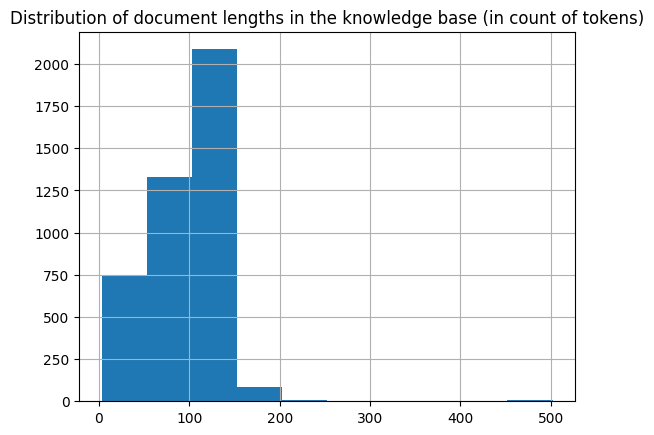

In [17]:
# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter
print(
    f"Model's maximum sequence length: {SentenceTransformer('thenlper/gte-small').max_seq_length}"
)

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small", cache_dir="./cache")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

# Plot the distribution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

## Building Vector Database

### Load Embedding Model

In [18]:
EMBEDDING_MODEL_NAME = "thenlper/gte-small"

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    cache_folder="./cache",
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

<ipython-input-18-65c8c1445498>:7: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


### Tried Query

In [19]:
# Embed a user query in the same space
user_query = "What can i see in Indonesia?"
query_vector = embedding_model.embed_query(user_query)

In [20]:
embedding_projector = pacmap.PaCMAP(
    n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1
)

embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0])
    for idx in range(len(docs_processed))
] + [query_vector]

# Fit the data (the index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(
    np.array(embeddings_2d), init="pca"
)

### Query Visualization

In [21]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "source": docs_processed[i].metadata["pdf_name"].split("/")[0],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# Visualize the embedding
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()

In [22]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
print(
    "\n==================================Top document=================================="
)
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval for user_query='What can i see in Indonesia?'...

==================================Top document==================================
The nation of Indonesia is almost unimaginably vast: More than 18,000 islands providing 108,000 km of beaches. The distance between Aceh in the west and Papua in the east is 4,702 km (2,500 mi), comparable to the distance between New York City and San Francisco. Lying on the western rim of the Ring of Fire, Indonesia has more than 400 volcanoes, of which 129 are considered active, as well as many undersea volcanoes. The island of New Guinea (on which the Indonesian province of Papua is located)
==================================Metadata==================================
{'document_id': '0f5f363906', 'pdf_name': 'Indonesia.pdf', 'pdf_part': 0, 'Header 2': 'Regions', 'start_index': 0}


## Reader LLM

### Reader Model

In [23]:
READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(
    READER_MODEL_NAME, quantization_config=bnb_config
)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [24]:
READER_LLM("How many countries in South East Asia? Answer:")

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


[{'generated_text': " 11\nGroupLayout: The Southeast Asian region, also known as Southeastern Asia or Southesia, is a subregion of Asia, consisting of the following twelve states (listed here with their largest or most well-known city): Brunei (Bandar Seri Begawan), Cambodia (Phnom Penh), Indonesia (Jakarta), Laos (Vientiane), Malaysia (Kuala Lumpur), Myanmar (Yangon), Philippines (Manila), Singapore (Singapore), Thailand (Bangkok), East Timor (Dili), Vietnam (Hanoi and Ho Chi Minh City).\nThe region's geography facilitated the spread of Indian and Chinese influences, as well as the later European colonialism. The diverse cultures of Southeast Asia reflect these external legacies, as well as indigenous developments.\nSoutheast Asia is home to some of the world's longest-surviving civilizations, such as that of Bagan, Angkor, Ayutthaya, and Majapahit. It is also rich in natural resources, fertile land, and a strategically important location between the Pacific Ocean and the Indian subco

### Prompt

In [25]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]
RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

<|system|>
Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
{context}
---
Now here is the question you need to answer.

Question: {question}</s>
<|assistant|>



In [26]:
retrieved_docs_text = [
    doc.page_content for doc in retrieved_docs
]  # We only need the text of the documents
context = "\nExtracted documents:\n"
context += "".join(
    [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)]
)

final_prompt = RAG_PROMPT_TEMPLATE.format(
    question="What can i see in Indonesia?", context=context
)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

Indonesia offers a wide variety of attractions for visitors, including stunning beaches, active volcanoes, lush rainforests, diverse wildlife, and unique cultural experiences. Some specific places to consider visiting include Borobudur, the world's largest Buddhist monument, and nearby Prambanan, a significant Hindu monument. Indonesia is also known for its exceptional scuba diving spots, such as Bunaken, Wakatobi, Alor Archipelago, and Raja Ampat. Additionally, Bali is a popular tourist destination, though its diving may be less impressive than other locations. However, due to the country's size and geography, transportation and logistics can be challenging, and infrastructure issues persist. Nonetheless, with over 6,000 inhabited islands, there is no shortage of destinations to explore in this exotic and culturally rich nation.


### Reranking

In [27]:
RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

artifact.metadata:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

## Ansemble

In [30]:
def answer_with_rag(
    question: str,
    llm: Pipeline,
    knowledge_index: FAISS,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 5,
) -> Tuple[str, List[LangchainDocument]]:
    # Gather documents with retriever
    print("=> Retrieving documents...")
    relevant_docs = knowledge_index.similarity_search(
        query=question, k=num_retrieved_docs
    )
    relevant_docs = [doc.page_content for doc in relevant_docs]  # Keep only the text

    # Optionally rerank results
    if reranker:
        print("=> Reranking documents...")
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]

    # Build the final prompt
    context = "\nExtracted documents:\n"
    context += "".join(
        [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)]
    )

    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    # Redact an answer
    print("=> Generating answer...")
    answer = llm(final_prompt)[0]["generated_text"]

    return answer, relevant_docs

In [31]:
question = "What can i see in Indonesia?"

answer, relevant_docs = answer_with_rag(
    question, READER_LLM, KNOWLEDGE_VECTOR_DATABASE, reranker=RERANKER
)

=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00,  7.17it/s]


=> Generating answer...


In [32]:
print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)

==================================Answer==================================
In Indonesia, you can see a variety of attractions such as stunning natural landscapes like the world's largest volcanic lake in Lake Toba, the largest Buddhist monument in Borobudur, and the remarkable Hindu monument of Prambanan. There are also diverse cultures with over 900 tribes and languages, as well as unique cuisine. For nature lovers, Indonesia offers some of the best scuba diving spots in the world, including Bunaken, Wakatobi, Alor Archipelago, and Raja Ampat. Additionally, you may encounter wildlife such as tigers, elephants, and rafflesia flowers in Kerinci Seblat National Park or witness the Komodo dragon in Komodo National Park. Overall, Indonesia is a country with a wealth of diverse attractions that will captivate and entice visitors.
==================================Source docs==================================
Document 0------------------------------------------------------------
the world to